In [41]:
import dicom, cv2, re, sys
import os, fnmatch, shutil, subprocess
import numpy as np
from PIL import Image
import dicom,  cv2, re, sys
import os, fnmatch, shutil, subprocess
from IPython.utils import io
import numpy as np
np.random.seed(1234)
import matplotlib as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # we ignore a RuntimeWarning produced from dividing by zero
import os, sys, urllib, gzip
import cPickle as pickle
sys.setrecursionlimit(10000)
import glob
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage

from PIL import Image
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.init import GlorotUniform
from lasagne.nonlinearities import rectify, leaky_rectify, tanh, sigmoid, softmax
from lasagne.updates import nesterov_momentum, adam
from lasagne.objectives import categorical_crossentropy, binary_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo
from lasagne.layers import Conv2DLayer as Conv2DLayer
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayer
import theano 
import theano.tensor as T
import lasagne
import time
try:
    from lasagne.layers.dnn import Conv2DDNNLayer as Conv2DLayer
    from lasagne.layers.dnn import MaxPool2DDNNLayer as MaxPool2DLayer
    print 'Using cuda_convnet (faster)'
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayer
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayer
    print 'Using lasagne.layers (slower)'
    
import theano
import theano.tensor as T

from lasagne.layers import Layer
from lasagne import init
from lasagne import nonlinearities
from scipy.misc import imresize, imread
from PIL import ImageOps
import scipy as sp
import scipy.ndimage.morphology
from skimage.morphology import convex_hull_image
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
import matplotlib.cm as cm
from scipy.optimize import minimize
from math import floor

Using lasagne.layers (slower)


In [244]:
def load_StereoImages(dirpath='/Users/louis/Documents/DepthMap_dataset'):
    # load training data
    X , X_left,X_right, y =[], [], [], []
    for path in glob.glob('%s/Depth_map/DepthMap*' % dirpath):
        with open(path, 'rb') as f:
            depthM = imread(f)
            size_depthM = depthM.shape
            depthM = Image.open(f)
            depthM = depthM.convert('L')
            depthM = np.array(depthM.getdata(),dtype=np.uint8)
        y.append(depthM)
    y = np.concatenate(y).reshape(-1, 1, size_depthM[0], size_depthM[1]).astype(np.float32)
    
    for path in glob.glob('%s/StereoImages/Stereoscopic*' % dirpath):
        with open(path, 'rb') as f:
            StereoIm = imread(f)
            size_StereoIm = StereoIm.shape
            StereoIm = Image.open(f)
            StereoIm = StereoIm.convert('L')
            StereoIm = np.array(StereoIm.getdata(),dtype=np.uint8).reshape(1, size_StereoIm[0], size_StereoIm[1])
            Im_left = StereoIm[0,...,0:size_StereoIm[1]/2]
            Im_right = StereoIm[0,...,size_StereoIm[1]/2:size_StereoIm[1]]
#             StereoIm = StereoIm.reshape(-1,1)
        X.append(StereoIm)
        X_left.append(Im_left)
        X_right.append(Im_right)
        
    X = np.concatenate((X_left,X_right),1).reshape(-1, 2, size_StereoIm[0], size_StereoIm[1]/2).astype(np.float32)
    X_left = np.concatenate(X_left).reshape(-1, 1, size_StereoIm[0], size_StereoIm[1]/2).astype(np.float32)
    X_right = np.concatenate(X_right).reshape(-1, 1, size_StereoIm[0], size_StereoIm[1]/2).astype(np.float32)
    
    
    
    print X_left.shape, X_right.shape, X.shape
    
    ii = np.random.permutation(len(X))
    X_train = X[ii[floor(len(X)*0.1):]]
    X_left_train = X_left[ii[floor(len(X_left)*0.1):]]
    X_right_train = X_right[ii[floor(len(X_right)*0.1):]]
    y_train = y[ii[floor(len(X)*0.1):]]
    
    X_valid = X[ii[:floor(len(X)*0.1)]]
    X_left_valid = X_left[ii[:floor(len(X_left)*0.1)]]
    X_right_valid = X_right[ii[:floor(len(X_right)*0.1)]]
    y_valid = y[ii[:floor(len(X)*0.1)]]
    
    # normalize to zero mean and unity variance
    offset = np.mean(X_train, 0)
    scale = np.std(X_train, 0).clip(min=1)
    
    offset_left = np.mean(X_left_train, 0)
    scale_left = np.std(X_left_train, 0).clip(min=1)
    offset_right = np.mean(X_right_train, 0)
    scale_right = np.std(X_right_train, 0).clip(min=1)
    
    X_train = (X_train - offset) / scale
    X_valid = (X_valid - offset) / scale
    
    X_left_train = (X_left_train - offset_left) / scale_left
    X_right_train = (X_right_train - offset_right) / scale_right

    X_left_valid = (X_left_valid - offset_left) / scale_left
    X_right_valid = (X_right_valid - offset_right) / scale_right
    return X_train,X_left_train,X_right_train, y_train, X_valid,X_left_valid,X_right_valid, y_valid
    

In [245]:
X_train,X_left_train,X_right_train, y_train, X_valid,X_left_valid,X_right_valid, y_valid = load_StereoImages()
print X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(500, 1, 200, 300) (500, 1, 200, 300) (500, 2, 200, 300)
(450, 2, 200, 300) (450, 1, 200, 300) (50, 2, 200, 300) (50, 1, 200, 300)


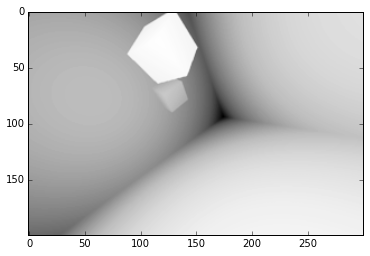

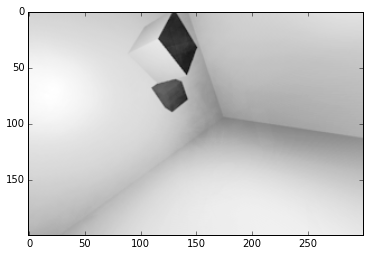

In [250]:
# y_train[11,0,...].shape
plt.imshow(y_train[1,0,...],cmap = cm.Greys_r)
plt.show()

plt.imshow(X_train[1,0,...],cmap = cm.Greys_r)
plt.show()
# plt.imshow(X_train[11,1,...],cmap = cm.Greys_r)
# plt.show()

In [185]:
from batchNormalization import BatchNormLayer

def batch_norm(layer, **kwargs):
    nonlinearity = getattr(layer, 'nonlinearity', None)
    if nonlinearity is not None:
        layer.nonlinearity = nonlinearities.identity
    if hasattr(layer, 'b') and layer.b is not None:
        del layer.params[layer.b]
        layer.b = None
    layer = BatchNormLayer(layer, **kwargs)
    if nonlinearity is not None:
        from lasagne.layers import NonlinearityLayer
        layer = NonlinearityLayer(layer, nonlinearity)
    return layer

In [218]:
def build_stereo_cnn(input_var=None):
    
    conv_num_filters1 = 16
    conv_num_filters2 = 32
    conv_num_filters3 = 32
    conv_num_filters4 = 32
    filter_size1 = 7
    filter_size2 = 5
    filter_size3 = 3
    filter_size4 = 3
    pool_size = 2
    scale_factor = 2
    pad_in = 'valid'
    pad_out = 'full'

    # Input layer, as usual:                                                                                                                                                                                
    network = InputLayer(shape=(None,2, X_train.shape[2], X_train.shape[3]),input_var=input_var,name="input_layer")                                                                                                                             
        
    network = batch_norm(Conv2DLayer(
            network, num_filters=conv_num_filters1, filter_size=(filter_size1, filter_size1),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv1"))
    
    network = MaxPool2DLayer(network, pool_size=(pool_size, pool_size),name="pool1")
    
    network = batch_norm(Conv2DLayer(
            network, num_filters=conv_num_filters2, filter_size=(filter_size2, filter_size2),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv2"))
    
    network = MaxPool2DLayer(network, pool_size=(pool_size, pool_size),name="pool2")
                                                                                                                                     
    network = batch_norm(Conv2DLayer(
            network, num_filters=conv_num_filters3, filter_size=(filter_size3, filter_size3),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv3"))
    
    network = MaxPool2DLayer(network, pool_size=(pool_size, pool_size),name="pool3")
                                                                                                                                     
    network = batch_norm(Conv2DLayer(
            network, num_filters=conv_num_filters4, filter_size=(filter_size4, filter_size4),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv4"))
    
    network = batch_norm(Conv2DLayer(
            network, num_filters=16, filter_size=(filter_size4, filter_size4),pad=pad_out,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="deconv1"))
    
    network = Upscale2DLayer(network, scale_factor=(pool_size, pool_size),name="upscale1")
    
    network = batch_norm(Conv2DLayer(
            network, num_filters=8, filter_size=(filter_size3, filter_size3),pad=pad_out,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="deconv2"))
    
    network = Upscale2DLayer(network, scale_factor=(pool_size, pool_size),name="upscale2")
    
    network = batch_norm(Conv2DLayer(
            network, num_filters=4, filter_size=(filter_size2, filter_size2),pad=pad_out,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="deconv3"))
    
    network = Upscale2DLayer(network, scale_factor=(pool_size, pool_size),name="upscale3")
    
    network = batch_norm(Conv2DLayer(
            network, num_filters=1, filter_size=(filter_size1, filter_size1),pad=pad_out,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform(),name="deconv4"))
                                 
    return network

def build_cnn2(input_var_left=None,input_var_right=None):
    
    conv_num_filters1 = 16
    conv_num_filters2 = 32
    conv_num_filters3 = 32
    conv_num_filters4 = 32
    filter_size1 = 7
    filter_size2 = 5
    filter_size3 = 3
    filter_size4 = 3
    pool_size = 2
    scale_factor = 2
    pad_in = 'valid'
    pad_out = 'full'

    # Input layers, left and right:                                                                                                                                                                                
    input_layer_left = InputLayer(shape=(None,1, X_left_train.shape[2], X_left_train.shape[3]),input_var=input_var_left,name="input_layer_left")   
    
    input_layer_right = InputLayer(shape=(None,1, X_right_train.shape[2], X_right_train.shape[3]),input_var=input_var_right,name="input_layer_right")   
        
    
    # First Conv layer with batch normalization, left and right:  
    Conv1_left = batch_norm(Conv2DLayer(
            input_layer_left, num_filters=conv_num_filters1, filter_size=(filter_size1, filter_size1),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv1_left"))
    
    Conv1_right = batch_norm(Conv2DLayer(
            input_layer_right, num_filters=conv_num_filters1, filter_size=(filter_size1, filter_size1),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv1_right"))
    
    # First max pool layer, left and right:  
    
    MaxPool1_left = MaxPool2DLayer(Conv1_left, pool_size=(pool_size, pool_size),name="pool1_left")
    
    MaxPool1_right = MaxPool2DLayer(Conv1_right, pool_size=(pool_size, pool_size),name="pool1_right")
    
    
    # Second Conv layer with batch normalization, left and right: # Second Conv layer with batch normalization, left and right:  
    
    Conv2_left = batch_norm(Conv2DLayer(
            Conv1_left, num_filters=conv_num_filters2, filter_size=(filter_size2, filter_size2),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv2_left"))
    
    Conv2_right = batch_norm(Conv2DLayer(
            Conv1_right, num_filters=conv_num_filters2, filter_size=(filter_size2, filter_size2),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv2_right"))
    
    # Second max pool layer, left and right:  
    
    MaxPool2_left = MaxPool2DLayer(Conv2_left, pool_size=(pool_size, pool_size),name="pool2_left")
    
    MaxPool2_right = MaxPool2DLayer(Conv2_right, pool_size=(pool_size, pool_size),name="pool2_right")
    
    
    # Third Conv layer with batch normalization, left and right: 
    
    Conv3_left = batch_norm(Conv2DLayer(
            MaxPool2_left, num_filters=conv_num_filters3, filter_size=(filter_size3, filter_size3),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv3_left"))
    
    Conv3_right = batch_norm(Conv2DLayer(
            MaxPool2_right, num_filters=conv_num_filters3, filter_size=(filter_size3, filter_size3),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv3_right"))
    
    # Third max pool layer, left and right:  
    
    MaxPool3_left = MaxPool2DLayer(Conv3_left, pool_size=(pool_size, pool_size),name="pool3_left")
    
    MaxPool3_right = MaxPool2DLayer(Conv3_right, pool_size=(pool_size, pool_size),name="pool3_right")
    
    
    # Fourth and final downward Conv layer with batch normalization, left and right: 
                                                                                                                                     
    Conv4_left = batch_norm(Conv2DLayer(
            MaxPool3_left, num_filters=conv_num_filters4, filter_size=(filter_size4, filter_size4),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv4_left"))
    
    Conv4_right = batch_norm(Conv2DLayer(
            MaxPool3_right, num_filters=conv_num_filters4, filter_size=(filter_size4, filter_size4),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv4_right"))
    
    # concatenate layer, join left and right images:
    
    ConcatLayer = ConcatLayer([Conv4_left,Conv4_right])
    
    network = batch_norm(Conv2DLayer(
            ConcatLayer, num_filters=16, filter_size=(filter_size4, filter_size4),pad=pad_out,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="deconv1"))
    
    network = Upscale2DLayer(network, scale_factor=(pool_size, pool_size),name="upscale1")
    
    network = batch_norm(Conv2DLayer(
            network, num_filters=8, filter_size=(filter_size3, filter_size3),pad=pad_out,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="deconv2"))
    
    network = Upscale2DLayer(network, scale_factor=(pool_size, pool_size),name="upscale2")
    
    network = batch_norm(Conv2DLayer(
            network, num_filters=4, filter_size=(filter_size2, filter_size2),pad=pad_out,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="deconv3"))
    
    network = Upscale2DLayer(network, scale_factor=(pool_size, pool_size),name="upscale3")
    
    network = batch_norm(Conv2DLayer(
            network, num_filters=1, filter_size=(filter_size1, filter_size1),pad=pad_out,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform(),name="deconv4"))
                                 
    return network

In [219]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def iterator(X, batchsize):
    indices = np.arange(len(X))
    for i in range(0, len(X) - batchsize + 1, batchsize):
        sli = indices[i:i+batchsize]
        yield X[sli]

In [220]:
def save_params(model, fn):
    with open(fn, 'w') as wr:
        pickle.dump(lasagne.layers.get_all_param_values(model), wr)
        
def dice_loss(predictions, targets):
    dice_index = 2*T.sum(predictions*targets)/((T.sum(predictions)+T.sum(targets)))
    return -dice_index


In [227]:
def main(model='cnn', num_epochs=200):
    # Load the dataset                                                                                                                                                                                      
    print("Loading data...")
    X_train,X_left_train,X_right_train, y_train, X_val,X_left_val,X_right_val, y_val = load_StereoImages()
    
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    
    y_train = y_train[...,1:y_train.shape[2]-1,3:y_train.shape[3]-3]
    y_val = y_val[...,1:y_val.shape[2]-1,3:y_val.shape[3]-3]
    
    print 'X_train type and shape:', X_train.dtype, X_train.shape
    print 'X_train.min():', X_train.min()
    print 'X_train.max():', X_train.max()

    print 'X_val type and shape:', X_val.dtype, X_val.shape
    print 'X_val.min():', X_val.min()
    print 'X_val.max():', X_val.max()
    
    print 'y_train type and shape:', y_train.dtype, y_train.shape
    print 'y_train.min():', y_train.min()
    print 'y_train.max():', y_train.max()

    print 'y_val type and shape:', y_val.dtype, y_val.shape
    print 'y_val.min():', y_val.min()
    print 'y_val.max():', y_val.max()

    # Prepare Theano variables for inputs and targets                                                                                                                                                       
    input_var = T.tensor4('inputs',dtype=theano.config.floatX)
    target_var = T.tensor4('targets',dtype=theano.config.floatX)

    # Create neural network model (depending on first command line parameter)                                                                                                                               
    print("Building model and compiling functions...")

    network = build_stereo_cnn(input_var)
    laylist = lasagne.layers.get_all_layers(network)
    
    for l in laylist:
        print l.name, lasagne.layers.get_output_shape(l)
        
    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    dloss = lasagne.objectives.squared_error(prediction, target_var)
    dloss = dloss.mean()
#     loss = lasagne.objectives.binary_crossentropy(prediction, target_var)
#     loss = loss.mean()
    
#     dloss = lasagne.objectives.squared_error(prediction, target_var)
#     dloss = dloss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.

    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
#     updates = lasagne.updates.adam(
#             loss, params, learning_rate=0.01)
    updates2 = lasagne.updates.adam(
            dloss, params, learning_rate=0.01)

    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
#     test_loss = lasagne.objectives.binary_crossentropy(test_prediction,
#                                                             target_var)
#     test_loss = test_loss.mean()
    
    test_loss2 = lasagne.objectives.squared_error(test_prediction,target_var)
    test_loss2 = test_loss2.mean()

    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
#     train_fn = theano.function([input_var, target_var], loss, updates=updates)
    
    train_fn2 = theano.function([input_var, target_var], dloss, updates=updates2)

    # Compile a second function computing the validation loss and accuracy:
#     val_fn = theano.function([input_var, target_var], [test_loss])
    
    val_fn2 = theano.function([input_var, target_var], [test_loss2])

    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:                                                                                                                                                                               
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 16, shuffle=True):
            inputs, targets = batch
            train_err += train_fn2(inputs, targets)
            train_batches += 1
#             print train_fn2(inputs, targets)
        # And a full pass over the validation data:
        val_err = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, 16, shuffle=False):
            inputs, targets = batch
            err = val_fn2(inputs, targets)
            val_err += err[0]
            val_batches += 1

        # Then we print the results for this epoch:                                                                                                                                                         
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  ratio:\t\t{:.6f}".format((train_err / train_batches)/(val_err / val_batches)))
#         filename = "model4_loss:\t\t{:.6f}".format(train_err / train_batches)
#         np.savez(filename, *lasagne.layers.get_all_param_values(network)) 
        np.savez('model_stereo.npz', *lasagne.layers.get_all_param_values(network)) 
        !git add model_stereo.npz
        !git commit -m "new stereo model"
        !git push -u origin master
        
    # After training, we compute and print the test error:                                                                                                                                                  
#     test_err = 0
#     test_acc = 0
#     test_batches = 0
#     for batch in iterator(X_test,32):
#         err = val_fn(batch)
#         test_err += err
#         test_batches += 1
        
#     print("Final results:")
#     print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    
    # Optionally, you could now dump the network weights to a file like this:                                                                                                                               
    np.savez('model_stereo.npz', *lasagne.layers.get_all_param_values(network))  
    !git add model_stereo.npz
    !git commit -m "new stereo model"
    !git push -u origin master
    #                                                                                                                                                                                                       
    # And load them again later on like this:                                                                                                                                                               
    # with np.load('model.npz') as f:                                                                                                                                                                       
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]                                                                                                                                     
    # lasagne.layers.set_all_param_values(network, param_values)  

In [228]:
main(model='cnn', num_epochs=45)

Loading data...
(500, 1, 200, 300) (500, 1, 200, 300) (500, 2, 200, 300)
(450, 1, 200, 300)
X_train type and shape: float32 (450, 2, 200, 300)
X_train.min(): -7.25551
X_train.max(): 5.45157
X_val type and shape: float32 (50, 2, 200, 300)
X_val.min(): -8.05825
X_val.max(): -3.27868
y_train type and shape: float32 (450, 1, 198, 294)
y_train.min(): 

INFO (theano.gof.compilelock): Refreshing lock /Users/louis/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-2.7.10-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/louis/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-2.7.10-64/lock_dir/lock


0.0
y_train.max(): 227.0
y_val type and shape: float32 (50, 1, 198, 294)
y_val.min(): 0.0
y_val.max(): 225.0
Building model and compiling functions...
input_layer (None, 2, 200, 300)
conv1 (None, 16, 194, 294)
None (None, 16, 194, 294)
None (None, 16, 194, 294)
pool1 (None, 16, 97, 147)
conv2 (None, 32, 93, 143)
None (None, 32, 93, 143)
None (None, 32, 93, 143)
pool2 (None, 32, 46, 71)
conv3 (None, 32, 44, 69)
None (None, 32, 44, 69)
None (None, 32, 44, 69)
pool3 (None, 32, 22, 34)
conv4 (None, 32, 20, 32)
None (None, 32, 20, 32)
None (None, 32, 20, 32)
deconv1 (None, 16, 22, 34)
None (None, 16, 22, 34)
None (None, 16, 22, 34)
upscale1 (None, 16, 44, 68)
deconv2 (None, 8, 46, 70)
None (None, 8, 46, 70)
None (None, 8, 46, 70)
upscale2 (None, 8, 92, 140)
deconv3 (None, 4, 96, 144)
None (None, 4, 96, 144)
None (None, 4, 96, 144)
upscale3 (None, 4, 192, 288)
deconv4 (None, 1, 198, 294)
None (None, 1, 198, 294)
None (None, 1, 198, 294)
Starting training...


KeyboardInterrupt: 

In [208]:
print y_train.shape

(450, 1, 200, 300)


In [8]:
def main(model='cnn', num_epochs=500):
    # Load the dataset                                                                                                                                                                                      
    print("Loading data...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()

    print('Train data shape: ', X_train.shape)
    print('Train labels shape: ', y_train.shape)
    print('Validation data shape: ', X_val.shape)
    print('Validation labels shape: ', y_val.shape)
    print('Test data shape: ', X_test.shape)
    print('Test labels shape: ', y_test.shape)

    # Prepare Theano variables for inputs and targets                                                                                                                                                       
    input_var = T.tensor4('inputs')
    #target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)                                                                                                                               
    print("Building model and compiling functions...")

    network = build_cae1(input_var)
    laylist = lasagne.layers.get_all_layers(network)
    
    with np.load('model.npz') as f:                                                                                                                                                                       
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]  
        
    lasagne.layers.set_all_param_values(network, param_values)  
    
    for l in laylist:
        print l.name, lasagne.layers.get_output_shape(l)
        
    # Create a loss expression for training, i.e., a scalar objective we want                                                                                                                               
    # to minimize (for our multi-class problem, it is the cross-entropy loss):                                                                                                                              
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.squared_error(prediction, input_var.flatten(2))
    loss = loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.                                                                                                                              

    # Create update expressions for training, i.e., how to modify the                                                                                                                                       
    # parameters at each training step. Here, we'll use Stochastic Gradient                                                                                                                                 
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.                                                                                                                                 
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference                                                                                                                               
    # here is that we do a deterministic forward pass through the network,                                                                                                                                  
    # disabling dropout layers.                                                                                                                                                                             
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.squared_error(test_prediction,
                                                            input_var.flatten(2))
    test_loss = test_loss.mean()
    # As a bonus, also create an expression for the classification accuracy:                                                                                                                                
    #test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), input_var.flatten(2)),dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving                                                                                                                              
    # the updates dictionary) and returning the corresponding training loss:                                                                                                                                
    #train_fn = theano.function([input_var, target_var], loss, updates=updates)
    train_fn = theano.function([input_var], loss, updates=updates)
    #out_fn = theano.function([input_var],prediction)
    #loss_fn = theano.function([input_var],loss)
    # Compile a second function computing the validation loss and accuracy:                                                                                                                                 
    #val_fn = theano.function([input_var, target_var], [test_loss, test_acc])
    val_fn = theano.function([input_var], test_loss)
    # Finally, launch the training loop.                                                                                                                                                                    
    print("Starting training...")
    loss_history = []
    # We iterate over epochs:                                                                                                                                                                               
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:                                                                                                                                          
        train_err = 0
        train_batches = 0
        start_time = time.time()
            
        for batch in iterator(X_train, 500):
            train_err += train_fn(batch)
            train_batches += 1
            loss_history.append(train_err)
        
        # And a full pass over the validation data:                                                                                                                                                         
        val_err = 0
        val_acc = 0
        val_batches = 0
        
        for batch in iterator(X_val, 500):
            err = val_fn(batch)
            val_err += err
            val_batches += 1
            

        # Then we print the results for this epoch:                                                                                                                                                         
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        np.savez('model.npz', *lasagne.layers.get_all_param_values(network))           
        
    # After training, we compute and print the test error:                                                                                                                                                  
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterator(X_test,500):
        err = val_fn(batch)
        test_err += err
        test_batches += 1
        
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    
    # Optionally, you could now dump the network weights to a file like this:                                                                                                                               
    np.savez('model.npz', *lasagne.layers.get_all_param_values(network))                                                                                                                                  
    #                                                                                                                                                                                                       
    # And load them again later on like this:                                                                                                                                                               
    # with np.load('model.npz') as f:                                                                                                                                                                       
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]                                                                                                                                     
    # lasagne.layers.set_all_param_values(network, param_values)  


In [9]:
 main()

Loading data...
('Train data shape: ', (49000, 3, 32, 32))
('Train labels shape: ', (49000,))
('Validation data shape: ', (1000, 3, 32, 32))
('Validation labels shape: ', (1000,))
('Test data shape: ', (10000, 3, 32, 32))
('Test labels shape: ', (10000,))
Building model and compiling functions...
InputLayer_0 (None, 3, 32, 32)
Conv2DLayer_1 (None, 32, 28, 28)
MaxPool2DLayer_3 (None, 32, 14, 14)
ReshapeLayer_6 (None, 6272)
dense_mid_7 (None, 100)
dense_mid_10 (None, 6272)
ReshapeLayer_11 (None, 32, 14, 14)
Upscale2DLayer_12 (None, 32, 28, 28)
Conv2DLayer_13 (None, 3, 32, 32)
ReshapeLayer_17 (None, 3072)
Starting training...
Epoch 1 of 500 took 13.356s
  training loss:		0.525950
  validation loss:		0.526529
Epoch 2 of 500 took 13.307s
  training loss:		0.525731
  validation loss:		0.526744
Epoch 3 of 500 took 13.267s
  training loss:		0.525639
  validation loss:		0.526725
Epoch 4 of 500 took 13.290s
  training loss:		0.525660
  validation loss:		0.526639
Epoch 5 of 500 took 13.283s
  tra

KeyboardInterrupt: 


  training loss:		0.520063
  validation loss:		0.521467


In [ ]:
plt.plot(np.array(loss_history).clip(max=3))
plt.xlabel('iteration')
plt.ylabel('loss')